In [32]:
import numpy as np
import cv2
import os
import open3d as o3d
import matplotlib.pyplot as plt
import json

In [35]:
# Load intrinsics
intrinsics_path = "objects/color_intrinsics.json"
with open(intrinsics_path, 'r') as f:
    color_ints = json.load(f)
    color_intrinsics = o3d.camera.PinholeCameraIntrinsic(
        width = color_ints["width"],
        height = color_ints["height"],
        fx = color_ints["fx"],
        fy = color_ints["fy"],
        cx = color_ints["ppx"],
        cy = color_ints["ppy"]
    )
color_intrinsics.intrinsic_matrix

array([[617.13928223,   0.        , 318.18209839],
       [  0.        , 617.77008057, 252.93757629],
       [  0.        ,   0.        ,   1.        ]])

In [37]:
color_path = "objects/color.npy"
depth_path = "objects/depth.npy"

color_image = np.load(color_path)
depth_image = np.load(depth_path)
print(color_image.shape, depth_image.shape)

(480, 640, 3) (480, 640)


In [40]:
# numpy to open3d
color_raw = o3d.geometry.Image(color_image)
depth_raw = o3d.geometry.Image(depth_image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, convert_rgb_to_intensity=False)
print(rgbd_image)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


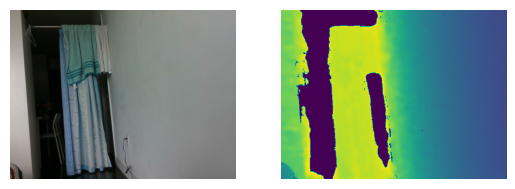

In [41]:
# Show both
plt.subplot(1, 2, 1)
plt.imshow(rgbd_image.color)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rgbd_image.depth)
plt.axis('off')
plt.show()

In [75]:
cam = o3d.camera.PinholeCameraParameters()
cam.intrinsic = color_intrinsics
cam.extrinsic = np.eye(4)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image, 
    cam.intrinsic, 
    cam.extrinsic
)

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Downsample for speed
pcd = pcd.voxel_down_sample(voxel_size=0.02)

pcd


PointCloud with 20496 points.

In [79]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd, origin], zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])

In [60]:
pcd.normals

std::vector<Eigen::Vector3d> with 0 elements.
Use numpy.asarray() to access data.

In [62]:
ply_fp = "bags/sample_color.ply"
ply_pc = o3d.io.read_point_cloud(
    ply_fp, remove_nan_points=False, remove_infinite_points=False)

In [64]:
ply_pc.normals

std::vector<Eigen::Vector3d> with 73541 elements.
Use numpy.asarray() to access data.

In [65]:
# Visualize
o3d.visualization.draw_geometries([ply_pc])